In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Run only once
!pip install numpy==1.23.5 --force-reinstall
!pip install catboost --force-reinstall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 73.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 wh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 115.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 120.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 128.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 126.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4

0:	learn: 2.2359882	test: 1.9449404	best: 1.9449404 (0)	total: 4.89ms	remaining: 4.88s
100:	learn: 1.0090302	test: 1.2186049	best: 1.2142943 (95)	total: 224ms	remaining: 2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.208741608
bestIteration = 130

Shrink model to first 131 iterations.

📊 Validation Results:
MAE: 85,735,792.64
RMSE: 196,887,540.64
Custom ±10M Accuracy: 56.00%

📊 Test Results:
MAE: 73,429,476.79
RMSE: 143,128,034.51
Custom ±10M Accuracy: 61.22%


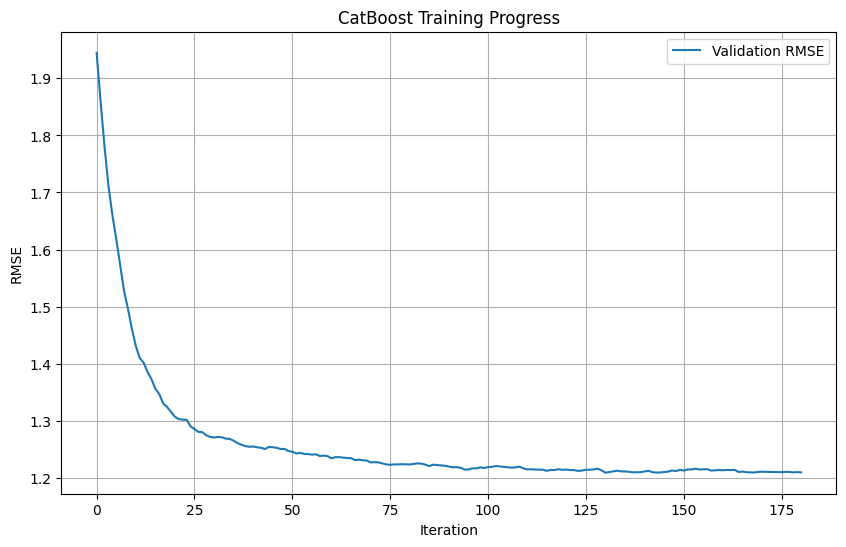

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt

# === 1. Loading cleaned dataset ===
df = pd.read_csv('/content/drive/MyDrive/movie_prediction_data/tmdb_1000_sample_cleaned.csv')

# === 2. Converting release_date to datetime format ===
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# === 3. Performing feature engineering ===
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month
df['cast_count'] = df['top_cast'].fillna('').str.split(', ').apply(len)
df['genre_count'] = df['genres'].fillna('').str.split(', ').apply(len)
df['keyword_count'] = df['keywords'].fillna('').str.split(', ').apply(len)

# Extracting top 50 directors and assigning others as 'other'
top_directors = df['director'].value_counts().nlargest(50).index
df['director_clean'] = df['director'].apply(lambda x: x if x in top_directors else 'other')

# Extracting top 50 production companies and assigning others as 'other'
df['main_prod_company'] = df['production_companies'].str.split(', ').str[0]
top_companies = df['main_prod_company'].value_counts().nlargest(50).index
df['main_prod_company'] = df['main_prod_company'].apply(lambda x: x if x in top_companies else 'other')

# Applying log transformation to revenue (target)
df['log_revenue'] = np.log1p(df['revenue'])

# === 4. Defining feature and target columns ===
features = [
    'budget', 'runtime', 'vote_average', 'vote_count', 'popularity',
    'release_year', 'release_month', 'cast_count', 'genre_count', 'keyword_count',
    'language', 'status', 'main_prod_company', 'director_clean'
]
target = 'log_revenue'

X = df[features]
y = df[target]

# === 5. Splitting data into training, validation, and test sets ===
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.15, random_state=42)

# === 6. Listing categorical feature names ===
cat_features = ['language', 'status', 'main_prod_company', 'director_clean']

# === 7. Initializing and training CatBoost model ===
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100
)

model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    cat_features=cat_features,
    use_best_model=True
)

# === 8. Defining evaluation function with custom ±10M accuracy ===
def evaluate(model, X, y_true, label):
    y_pred = model.predict(X)
    y_pred_rev = np.expm1(y_pred)
    y_true_rev = np.expm1(y_true)

    mae = mean_absolute_error(y_true_rev, y_pred_rev)
    rmse = np.sqrt(mean_squared_error(y_true_rev, y_pred_rev))
    within_range = np.abs(y_pred_rev - y_true_rev) <= 10000000  # ±10M
    custom_acc = np.mean(within_range)

    print(f"\n📊 {label} Results:")
    print(f"MAE: {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"Custom ±10M Accuracy: {custom_acc * 100:.2f}%")

# === 9. Evaluating model on validation and test sets ===
evaluate(model, X_val, y_val, "Validation")
evaluate(model, X_test, y_test, "Test")

# === 10. Plotting CatBoost training progress ===
def plot_training_progress(model):
    evals = model.get_evals_result()
    rmse_vals = evals['validation']['RMSE']

    plt.figure(figsize=(10, 6))
    plt.plot(rmse_vals, label='Validation RMSE')
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    plt.title('CatBoost Training Progress')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_progress(model)
